In [4]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [5]:
%%script echo skipping
gt = cv2.imread("03_GT.png")/255
cv2_imshow(gt*255)

skipping


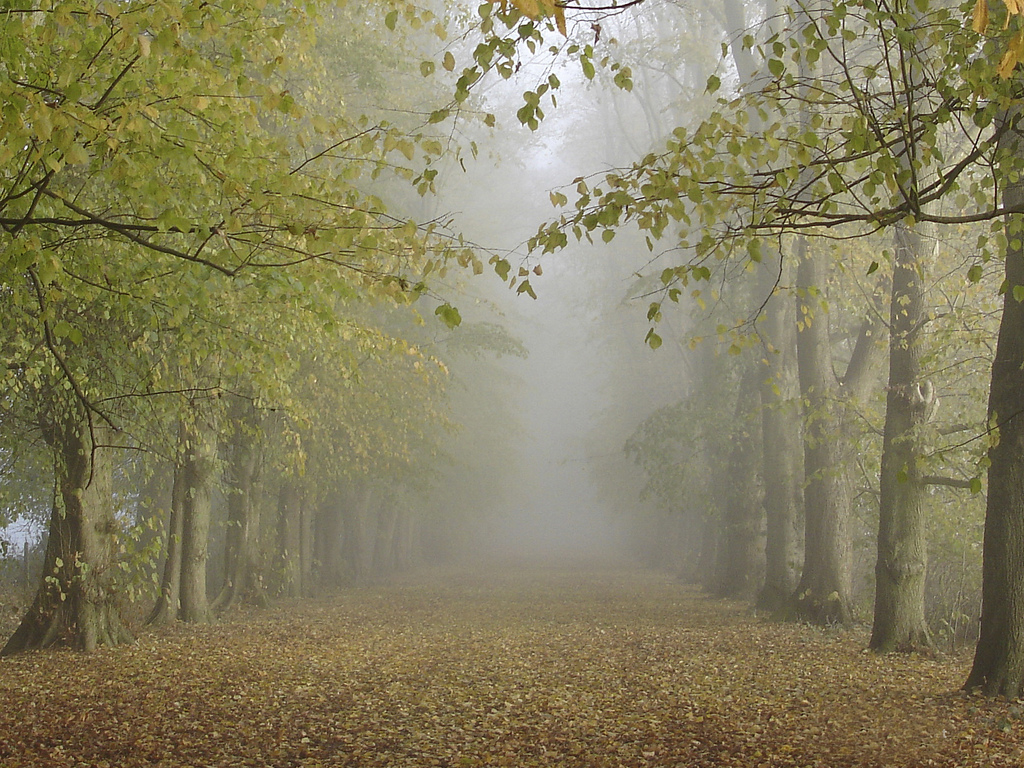

In [6]:
img = cv2.imread("forest.jpg").astype('float64')/255
cv2_imshow(img*255)

# Dark channel computation

In [7]:
PATCH_SIZE=5
MOVE = int(PATCH_SIZE//2)

In [8]:
# dark channel should have the same shape as the original image

# out_shape = (img.shape[0] - PATCH_SIZE//2, img.shape[1] - PATCH_SIZE//2, 1)
out_shape = img.shape
darkC = np.zeros((out_shape[0],out_shape[1]), dtype=np.float32)

padded_img = cv2.copyMakeBorder(img, top=PATCH_SIZE//2, bottom=PATCH_SIZE//2, left=PATCH_SIZE//2, right=PATCH_SIZE//2, borderType=cv2.BORDER_REFLECT)
# iterate over all the channels
# iterate over patches
for i in range(darkC.shape[0]):
    for j in range(darkC.shape[1]):
        # min across channels
        min_overall = np.inf
        # minimum in this color channel
        chan_min = np.amin(padded_img[i:i+PATCH_SIZE, j:j+PATCH_SIZE])
        if chan_min < min_overall:
            min_overall = chan_min
            
        darkC[i, j] = min_overall

In [9]:
print(np.min(darkC), np.max(darkC))

0.0 0.9372549


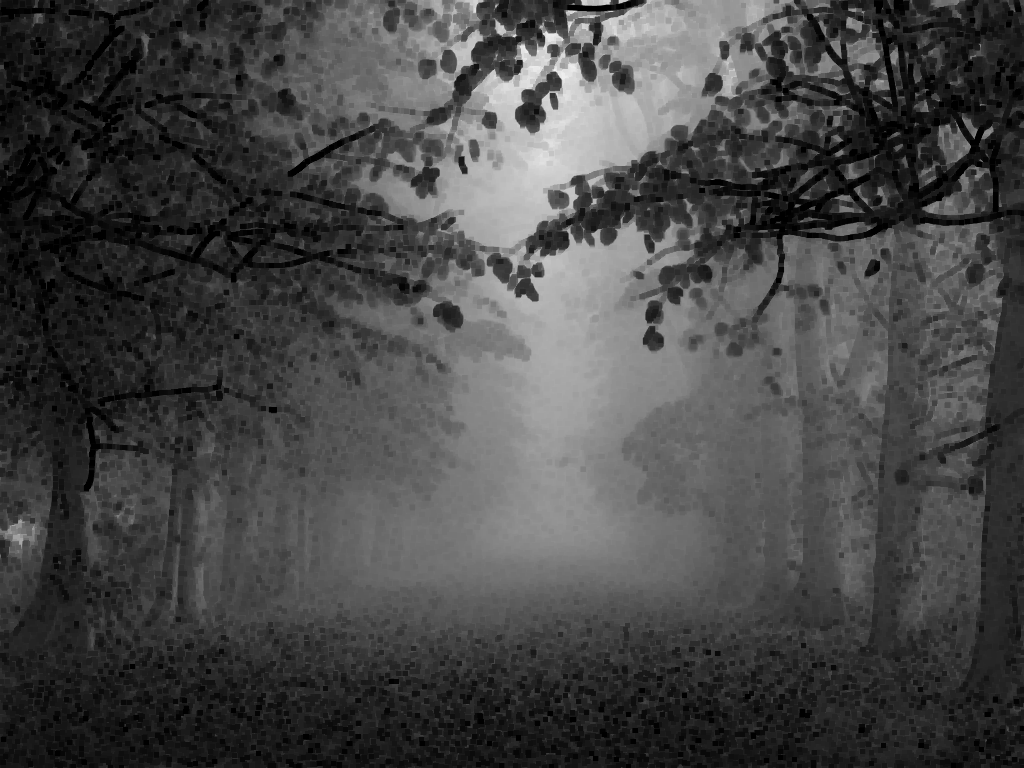

In [10]:
cv2_imshow(darkC*255)

# Atmospheric light computation


## Brightest pixel method

In [11]:
A = np.max(img)

## Using dark channel prior

In [12]:
# get the top 0.1% pixels from the dark channel, maintain a max heap to do that
import heapq

h = []
for i in range(darkC.shape[0]):
    for j in range(darkC.shape[1]):
        heapq.heappush(h, (darkC[i, j].item(), (i, j)))


HOW_MANY = int(0.1/100 * len(img.flatten()))

top = heapq.nlargest(HOW_MANY, h)
print(f"Top 0.1% of the pixels in the dark channel: {len(top)} pixels out of {len(img.flatten())} pixels in total")

topPix = []
for _, pix in top:
    topPix.append(pix)

# iterate over all the pixels to find the highest intensity values
A = np.zeros(3)
for px, py in topPix:
    A += img[px,py]
    # coord = (*coord, 0)
    # # print(coord, A, img[coord, 0])
    # A = max(A, img[coord])
A = A/len(topPix)

print(A)
print(np.max(img))

Top 0.1% of the pixels in the dark channel: 2359 pixels out of 2359296 pixels in total
[0.9394692  0.90827286 0.89831683]
1.0


# Calculate Tramission map t_hat

In [13]:
OMEGA = 0.95
t_hat = np.ones(darkC.shape, dtype='float64') - OMEGA * darkC

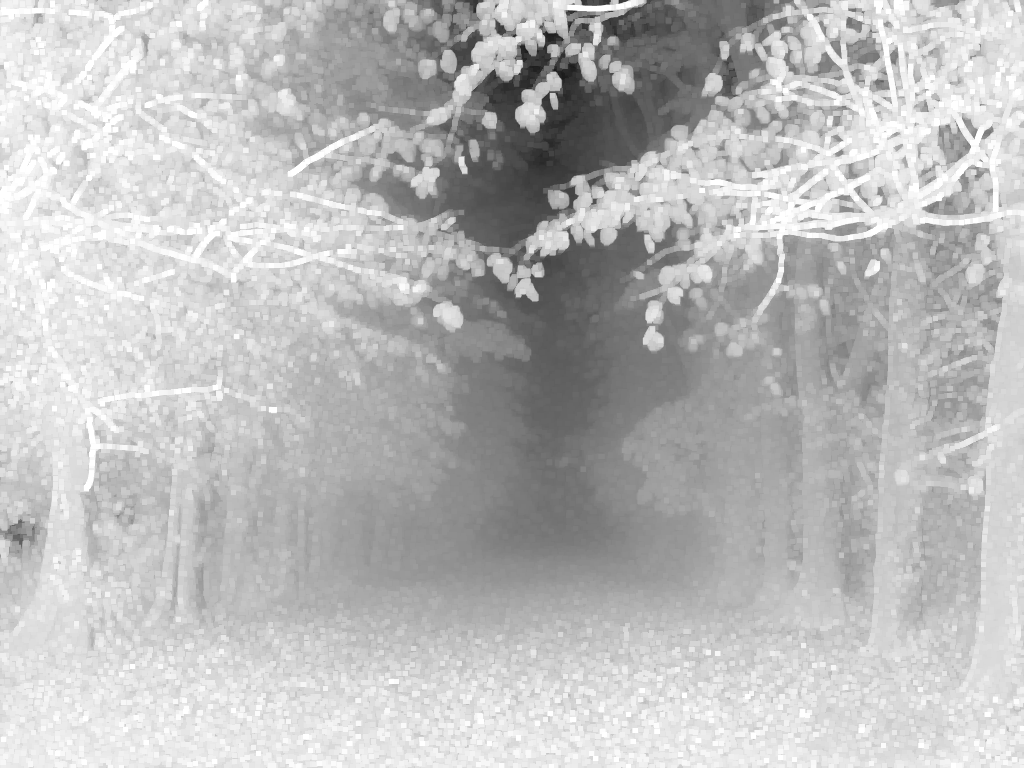

In [14]:
cv2_imshow(t_hat*255)

# Soft matting

## soft matting using pymatting library

In [15]:
# !pip install pymatting

### using pymatting.uniform_laplacian to calculate L matrix

In [16]:
%%script echo skipping
import pymatting

# L = pymatting.cf_laplacian(img,  radius=20)
L = pymatting.uniform_laplacian(img)

skipping


In [17]:
# L.shape

In [18]:
%%script echo skipping
from scipy.sparse import identity, linalg

LAMBDA = 10e-4
left = L + (LAMBDA * identity(L.shape[0]))
left_inv = linalg.inv(left)

skipping


In [19]:
%%script echo skipping
t = np.matmul(left_inv * LAMBDA, t_hat)

skipping


issue: L matrix is huge and final matrix multiplication exceeds memory

### using estimate_alpha_cf

In [20]:
%%script echo skipping
norm = (t_hat - t_hat.min()) / (t_hat.max() - t_hat.min()) 
# norm = t_hat - t_hat.min()

alpha = pymatting.alpha.estimate_alpha_cf(img, norm, laplacian_kwargs={"epsilon": 1e-6})
t = alpha

skipping


issue: if we don't normalize the t_hat transmission map, the below function complain that array doesn't contain >=0.9 or <=0.1 value\
image also doesn't look good after normalizing

In [21]:
%%script echo skipping
cv2_imshow(alpha*255)

skipping


# Guided Filter

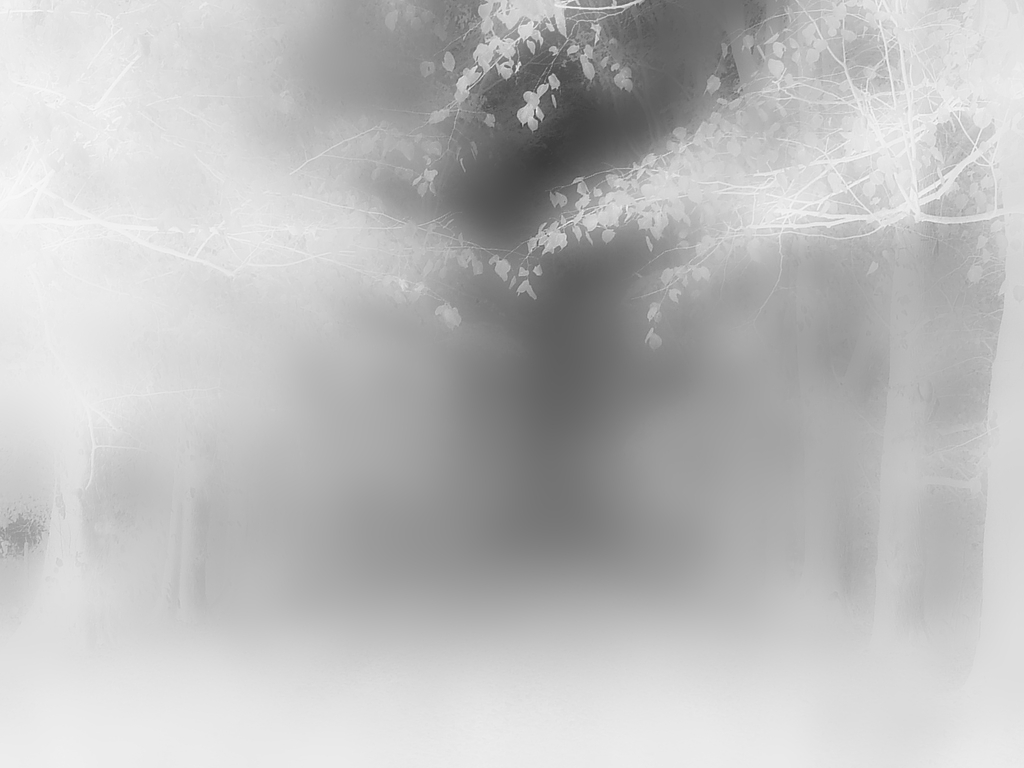

In [22]:
from cv2.ximgproc import guidedFilter
gray = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2GRAY)
t = guidedFilter(gray, t_hat.astype('float32'), radius=20, eps=10e-3)
cv2_imshow(t*255)


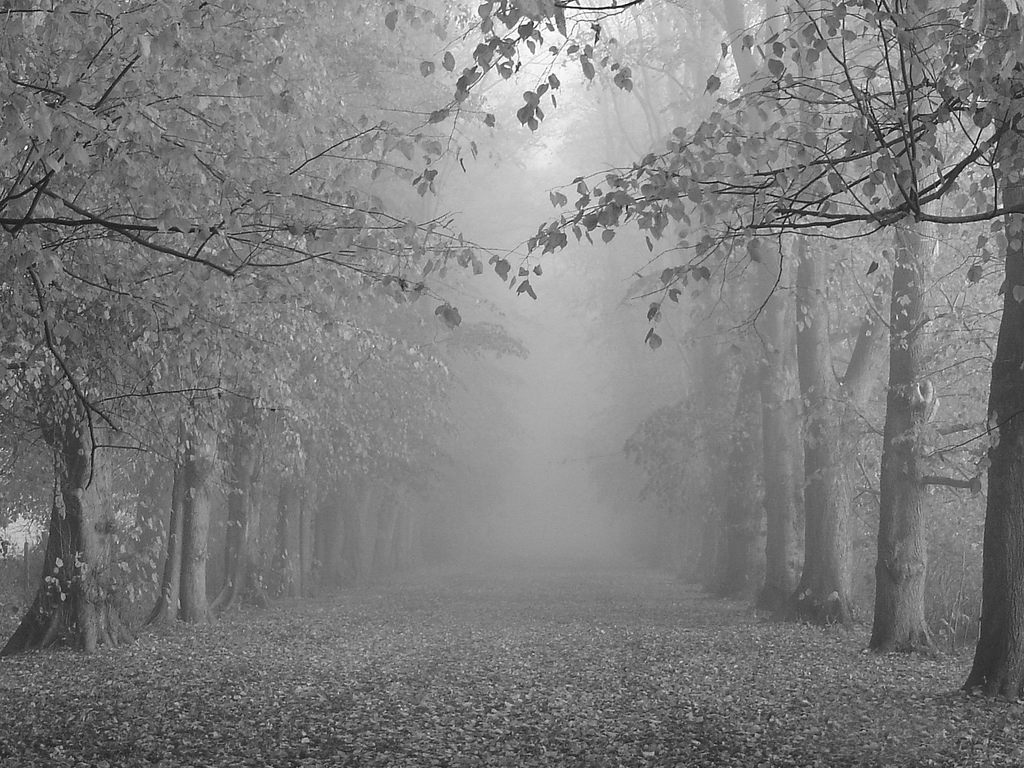

In [23]:
cv2_imshow(gray*255)

# Recover haze-free Image

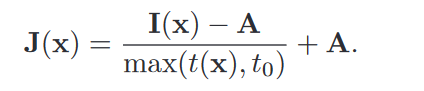

In [1]:
t_0 = 0.1
J = np.zeros(img.shape, dtype='float64')
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        J[i,j] = ((img[i,j] - A) / max(t[i,j], t_0)) + A
        
cv2_imshow(J*255)

NameError: ignored

In [25]:
t_hat.shape

(768, 1024)

In [26]:
img.shape

(768, 1024, 3)